# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [6]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [7]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [8]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9368 / 11441 MB available


In [9]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}


__global__ void addMatrixKernel(float* c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    //Pseudocode
    //c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];

}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

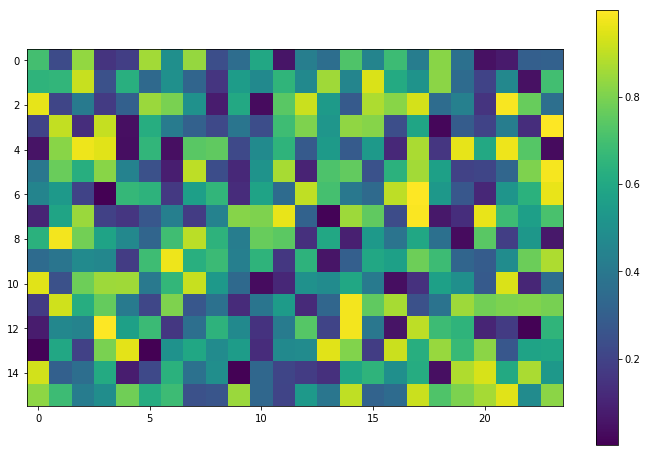

In [10]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show()



In [12]:
print(a.shape)

(16, 24)


In [13]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [14]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [19]:
#a.shape=(rows, cols) => (y, x)
domain_size = (a.shape[1],a.shape[0]) #domain_size (x, y)
block_size = (8, 4, 1) #these need to be (x, y, z)
grid_size = (domain_size[0] // block_size[0], domain_size[1]//block_size[1],1)

print("Domain size is" + str(domain_size))
print("Block size is" + str(block_size))
print("Grid size is" + str(grid_size))

Domain size is(24, 16)
Block size is(8, 4, 1)
Grid size is(3, 4, 1)


In [22]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.582273  , 0.6053362 , 1.3915288 , 1.0718361 , 0.85476565,
        1.8260131 , 0.8120688 , 0.9799354 , 0.7487793 , 0.920273  ,
        1.307342  , 0.7655075 , 1.2025385 , 1.0213708 , 1.1953632 ,
        0.9774535 , 0.7103076 , 0.7971587 , 1.6920054 , 0.69905293,
        0.13549091, 0.28124636, 0.4489905 , 1.1212287 ],
       [0.684755  , 1.3635907 , 1.3997867 , 0.54822993, 0.6989029 ,
        0.5787893 , 1.4174986 , 0.53684306, 1.0068322 , 1.2104297 ,
        0.87714463, 0.74460304, 1.0778574 , 1.8228748 , 1.0815787 ,
        1.326149  , 0.8305589 , 1.4080584 , 0.9462984 , 1.1681377 ,
        0.81401825, 0.7113296 , 0.9104987 , 1.1668836 ],
       [1.5654316 , 0.6021084 , 1.2535498 , 0.66456306, 0.96625936,
        1.3984753 , 1.3681593 , 1.4584982 , 0.49935192, 0.9223521 ,
        0.7611207 , 0.85480285, 1.6024678 , 0.9483594 , 0.4115011 ,
        1.7973261 , 1.1783557 , 1.0932567 , 1.0790768 , 1.333998  ,
        1.0405729 , 1.9576616 , 0.94561154, 0.6683275 ],
       [0.279

In [23]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.582273   0.6053362  1.3915288  1.0718361  0.85476565 1.8260131
  0.8120688  0.9799354  0.7487793  0.920273   1.307342   0.7655075
  1.2025385  1.0213708  1.1953632  0.9774535  0.7103076  0.7971587
  1.6920054  0.69905293 0.13549091 0.28124636 0.4489905  1.1212287 ]
 [0.684755   1.3635907  1.3997867  0.54822993 0.6989029  0.5787893
  1.4174986  0.53684306 1.0068322  1.2104297  0.87714463 0.74460304
  1.0778574  1.8228748  1.0815787  1.326149   0.8305589  1.4080584
  0.9462984  1.1681377  0.81401825 0.7113296  0.9104987  1.1668836 ]
 [1.5654316  0.6021084  1.2535498  0.66456306 0.96625936 1.3984753
  1.3681593  1.4584982  0.49935192 0.9223521  0.7611207  0.85480285
  1.6024678  0.9483594  0.4115011  1.7973261  1.1783557  1.0932567
  1.0790768  1.333998   1.0405729  1.9576616  0.94561154 0.6683275 ]
 [0.27909157 1.3226154  0.7206613  1.5353844  0.2186843  1.5465565
  1.1155473  0.918882   0.78851664 0.8998929  0.8579803  0.73776513
  0.8542892  1.3555745  1.5447303  1.3086263  

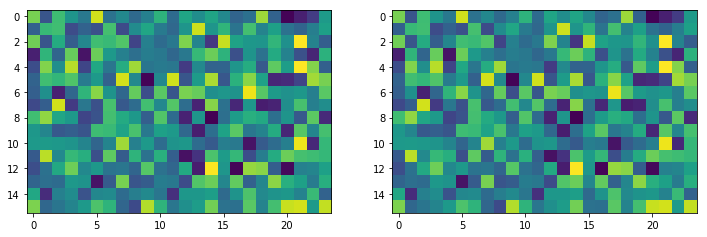

In [25]:
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)